## Basic Imports

In [10]:
import pandas as pd                     # Working with data
import matplotlib.pyplot as plt         # Plotting some outputs obtained from classifiers and data analysis
import tqdm                             # Plotting progress bar

import base64
import io
import json

import networkx as nx                   # Drawing the dataset hierarchy

import os                               # Working with addresses
import sys

---
## Sample data

This dataset is organized to model a **hierarchical multi-class classification** problem, where items (like products or entertainment media) are classified into categories at different levels of a hierarchy.

### **Structure of the Dataset:**
- **Title**: The name or title of the item (e.g., a product or media name).
- **Text**: A descriptive passage about the item, which could include reviews, detailed descriptions, or personal opinions.
- **Cat1, Cat2, Cat3**: These represent hierarchical levels of classification:
- **Cat1**: The broadest category (e.g., "toys games" or "grocery gourmet food").
- **Cat2**: A subcategory within Cat1 (e.g., "games" under "toys games").
- **Cat3**: The most specific subcategory within Cat2 (e.g., "board games" under "games").
- **flat_cat**: A combined representation of the hierarchical levels (**Cat1, Cat2, Cat3**) as a tuple, for easy access to the full hierarchy.

__Note:__ It is assumed that the different levels of the hierarchy are labelled according to a certain pattern. Here the pattern is "Cat" followed by the level number. This is important because one of the parameters passed to the model is a regular expression that is used by `pandas` to extract only those columns which form the (hierarchical) labels.

### **Purpose:**
The goal is to train several machine learning models that classify or predict category levels for new items based on input features (**Title** or **Text**).
        

### **Sample Data Demonstration**

/tmp/ipykernel_11350/1641666293.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


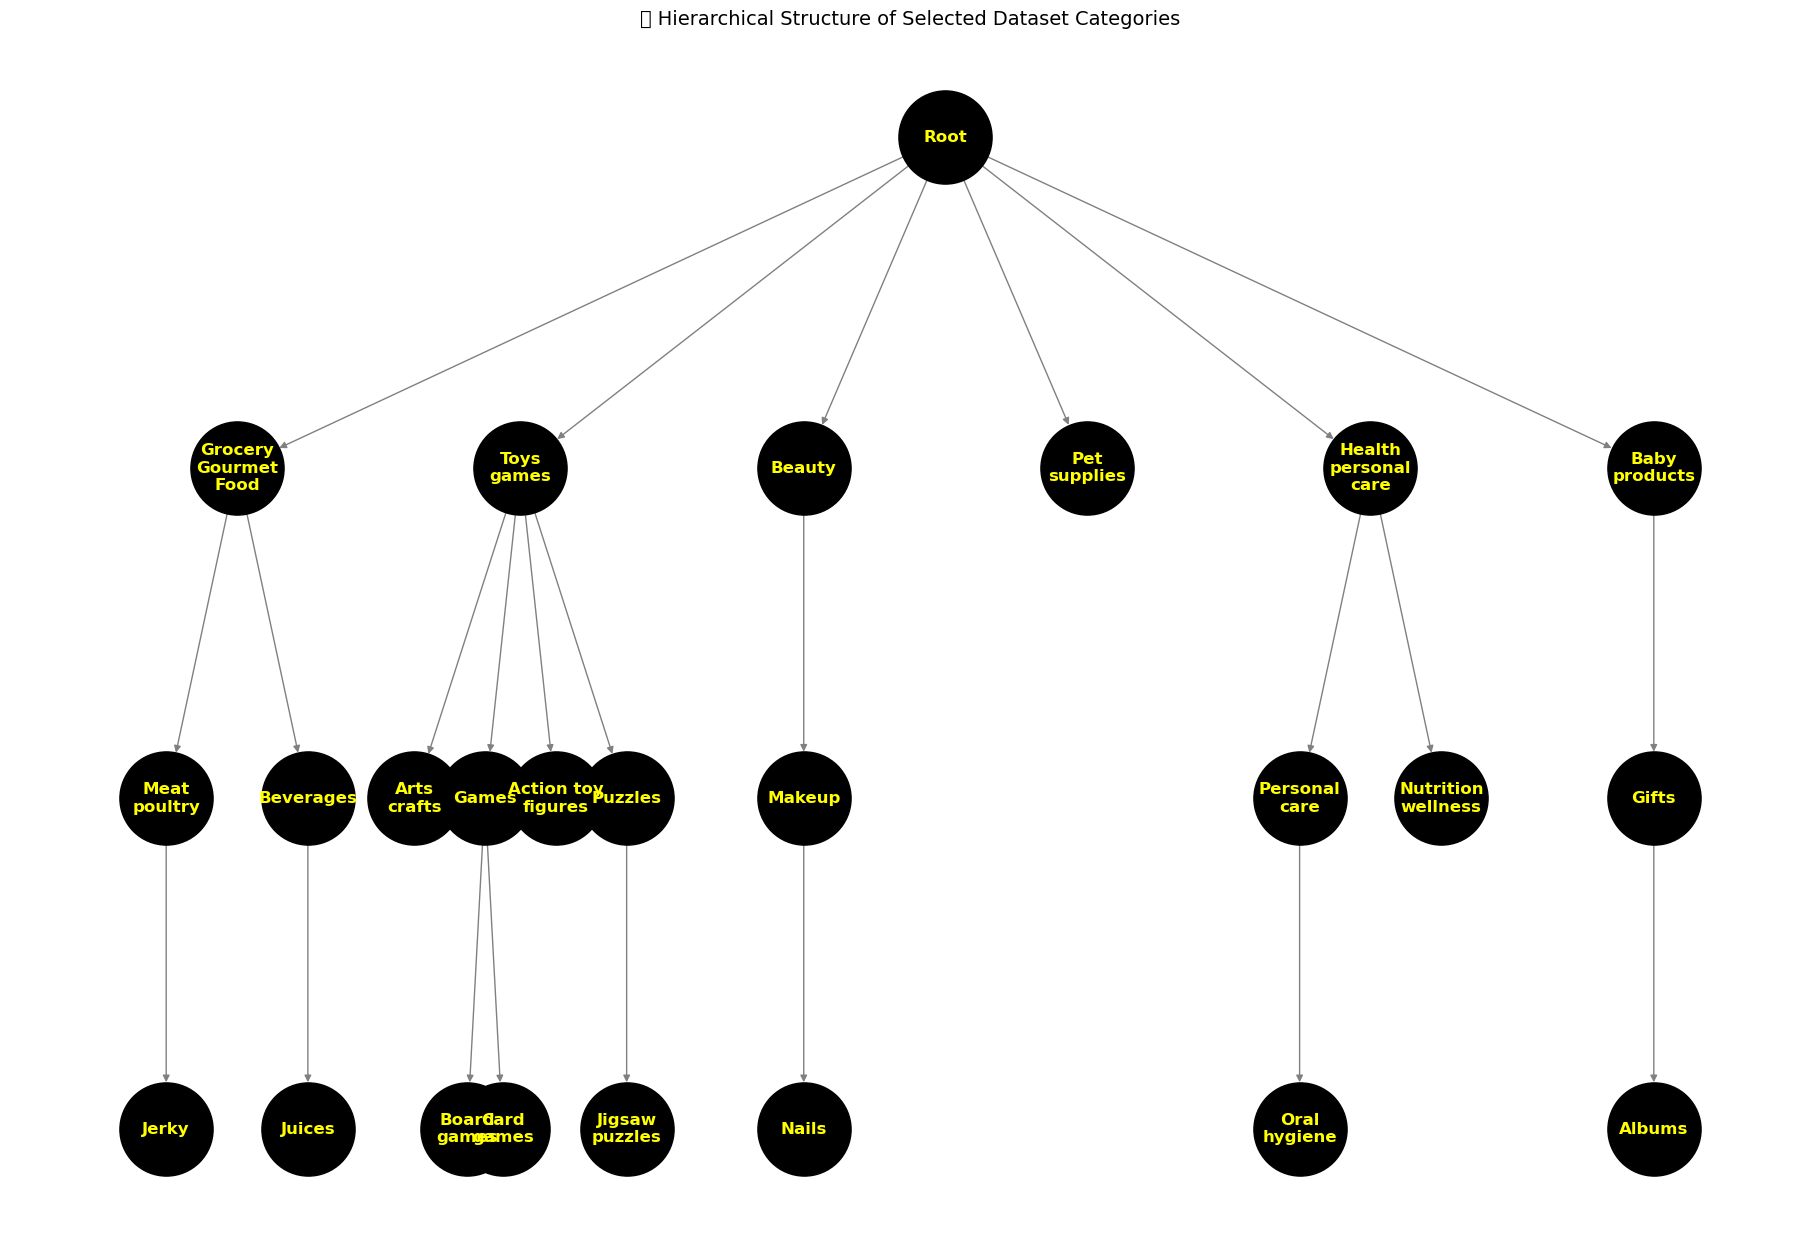

,Title,Text,Cat1,Cat2,Cat3,flat_cat
0,Golden Valley Natural Buffalo Jerky,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky,"('grocery gourmet food', 'meat poultry', 'jerky')"
1,I SPY A is For Jigsaw Puzzle 63pc,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles,"('toys games', 'puzzles', 'jigsaw puzzles')"
2,ThinkFun Rush Hour,"My eight year old loves this game, whenever he...",toys games,games,board games,"('toys games', 'games', 'board games')"
3,Beetle Juice (1988),The real joy of this movie doesn't lie in its ...,grocery gourmet food,beverages,juices,"('grocery gourmet food', 'beverages', 'juices')"
4,Beetle Juice [VHS] (1988),"Okay, Tim Burton is genuine. He haunts you wit...",grocery gourmet food,beverages,juices,"('grocery gourmet food', 'beverages', 'juices')"
5,Boundaries,"Boundaries, along with counseling, has given m...",beauty,makeup,nails,"('beauty', 'makeup', 'nails')"
6,Crayola 120ct Original Crayons,120 colors? I say 120 sticks of fun! And a fre...,toys games,arts crafts,drawing painting supplies,"('toys games', 'arts crafts', 'drawing paintin..."
7,Crayola 120ct Original Crayons,"What a wonderful creation. Art, in our house, ...",toys games,arts crafts,drawing painting supplies,"('toys games', 'arts crafts', 'drawing paintin..."
8,Blue's Clues How To Host A [Toy],"My 4 year old loves Blue, but found this produ...",toys games,games,board games,"('toys games', 'games', 'board games')"
9,Pokemon Battle Figures #94 Gengar & #52 Meowth...,"Meowth is the coolest, lots of play value. Gre...",toys games,action toy figures,figures,"('toys games', 'action toy figures', 'figures')"


In [16]:
# Loading training and test data

train_data_location = './data/kaggle_data/train.csv'
test_data_location  = './data/kaggle_data/test.csv'

train = pd.read_csv(train_data_location)
test = pd.read_csv(test_data_location)

# Function to create graph of dataset hierarchy 
def create_graph():
    G = nx.DiGraph()

    # Define hierarchical structure
    categories = {
        "Root": ["Grocery\nGourmet\nFood", "Toys\ngames", "Beauty", "Pet\nsupplies", "Health\npersonal\ncare", "Baby\nproducts"],  
        "Grocery\nGourmet\nFood": ["Meat\npoultry", "Beverages"],
        "Meat\npoultry": ["Jerky"],
        "Beverages": ["Juices"],
        "Toys\ngames": ["Arts\ncrafts", "Games", "Action toy\nfigures", "Puzzles"],
        "Games": ["Board\ngames", "Card\ngames"],
        "Puzzles": ["Jigsaw\npuzzles"],
        "Beauty": ["Makeup"],
        "Makeup": ["Nails"],
        "Health\npersonal\ncare": ["Personal\ncare", "Nutrition\nwellness"],
        "Baby\nproducts": ["Gifts"],
        "Gifts": ["Albums"],
        "Personal\ncare": ["Oral\nhygiene"],
    }

    # Add edges to the graph
    for parent, children in categories.items():
        for child in children:
            G.add_edge(parent, child)

    # Generate manual layered layout for hierarchy
    def hierarchy_pos(G, root='Root', width=2., vert_gap=0.6, vert_loc=0, xcenter=0.5, pos=None, parent=None):
        pos = pos or {}
        children = list(G.successors(root))
        if not children:
            pos[root] = (xcenter, vert_loc)
        else:
            dx = width / len(children)
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                    vert_loc=vert_loc - vert_gap, xcenter=nextx, pos=pos, parent=root)
            pos[root] = (xcenter, vert_loc)
        return pos

    pos = hierarchy_pos(G)

    # Plot the graph
    plt.figure(figsize=(18, 12))
    nx.draw(
        G, pos, with_labels=True, node_color='black', edge_color='gray',
        node_size=4500, font_size=12, font_color='yellow', font_weight='bold', arrows=True
    )
    plt.title("🧭 Hierarchical Structure of Selected Dataset Categories", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
create_graph()

# Displaying top 10 rows of data
train.head(10)

# 🧠 Data Analysis Summary

The following cells provide structured insights into code and category distributions in the training and test datasets.


In [17]:
# Number of unique codes in both training and test data

print(f'The training data has {len(train):,} records across {train.flat_cat.nunique()} codes.')
print(f'The test data has {len(test):,} records across {train.flat_cat.nunique()} codes.\n')

# Number of training and test data that have the rarest code

print(f'{train.flat_cat.value_counts().min()} record(s) in the training data has the rarest code.')
print(f'{test.flat_cat.value_counts().min()} record(s) in the training data has the rarest code.\n')

min_count = train.flat_cat.value_counts().min()
rarest_codes = train.flat_cat.value_counts()[train.flat_cat.value_counts() == min_count].index

print(f'The rarest codes in the training dataset are:')
print(rarest_codes)

The training data has 36,369 records across 322 codes.
The test data has 9,046 records across 322 codes.

10 record(s) in the training data has the rarest code.
1 record(s) in the training data has the rarest code.

The rarest codes in the training dataset are:
Index(['('pet supplies', 'bunny rabbit central', 'food')',
       '('beauty', 'makeup', 'body')',
       '('toys games', 'sports outdoor play', 'ball pits accessories')',
       '('pet supplies', 'fish aquatic pets', 'health supplies')',
       '('grocery gourmet food', 'cooking baking supplies', 'nuts seeds')',
       '('health personal care', 'personal care', 'body art')',
       '('pet supplies', 'small animals', 'food')',
       '('toys games', 'stuffed animals plush', 'plush puppets')',
       '('grocery gourmet food', 'candy chocolate', 'jelly beans')'],
      dtype='object', name='flat_cat')


In [18]:
import sys
sys.path.append("./helper")

from display_utils import display_code_differences_between_sets

display_code_differences_between_sets(train.flat_cat, test.flat_cat)

## 🧱 Category-Level Distribution in Training Data

,Top 10 Cat1,count
0,health personal care,9421
1,toys games,8779
2,beauty,5495
3,baby products,5217
4,pet supplies,4786
5,grocery gourmet food,2671


,Top 10 Cat2,count
0,personal care,2816
1,dogs,2610
2,nutrition wellness,2186
3,health care,1938
4,cats,1772
5,hair care,1715
6,games,1364
7,skin care,1288
8,medical supplies equipment,1265
9,fragrance,1127


,Top 10 Cat3,count
0,shaving hair removal,1565
1,vitamins supplements,1315
2,board games,924
3,styling tools,850
4,women s,737
5,face,729
6,toys,679
7,dolls,653
8,figures,653
9,oral hygiene,642



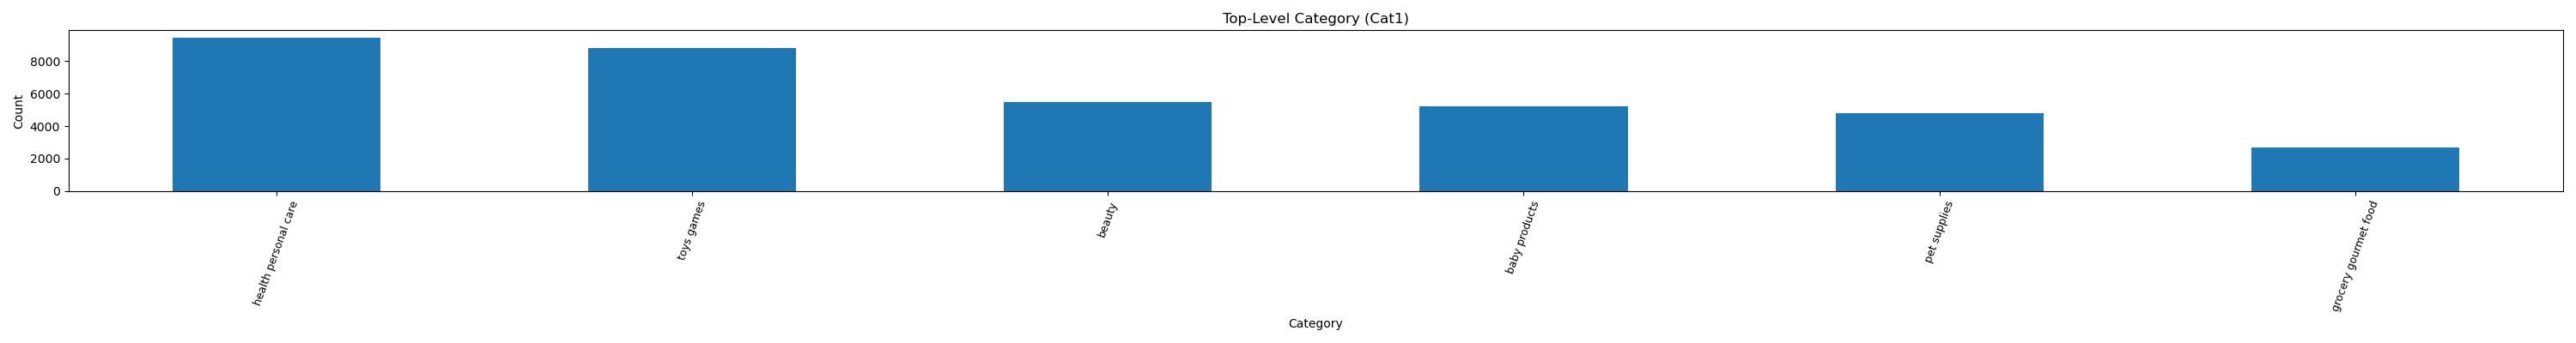


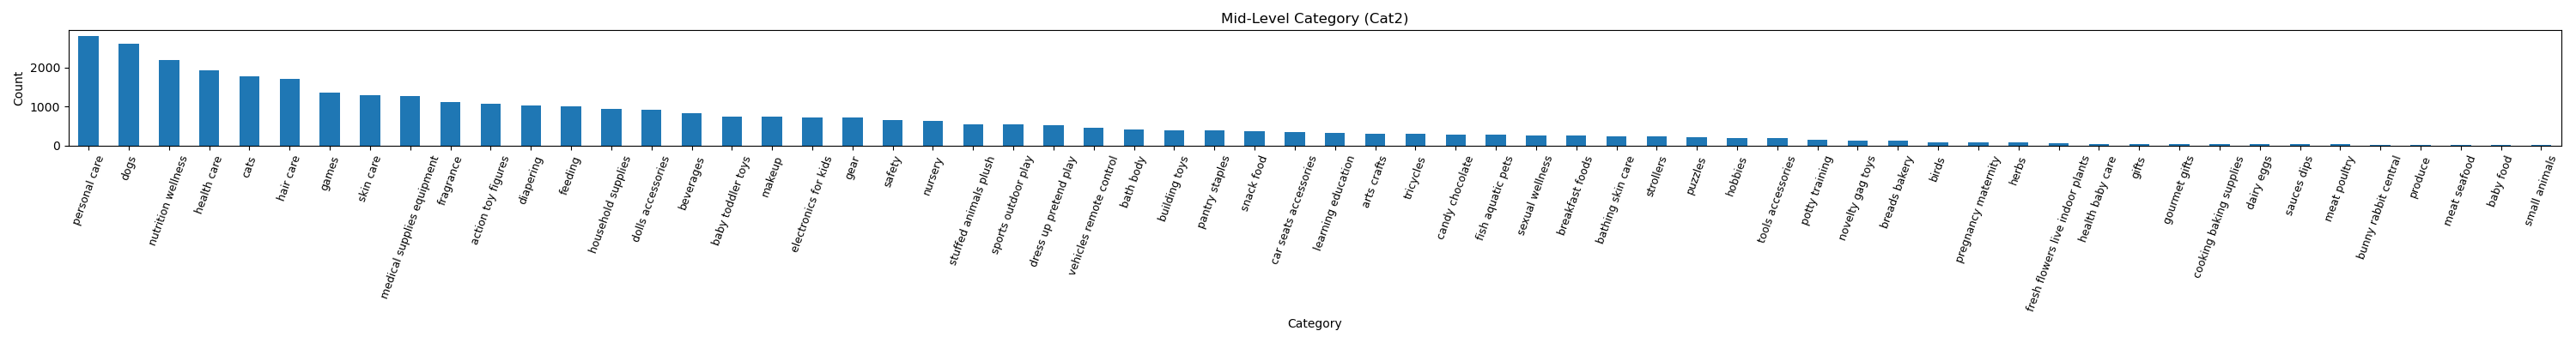


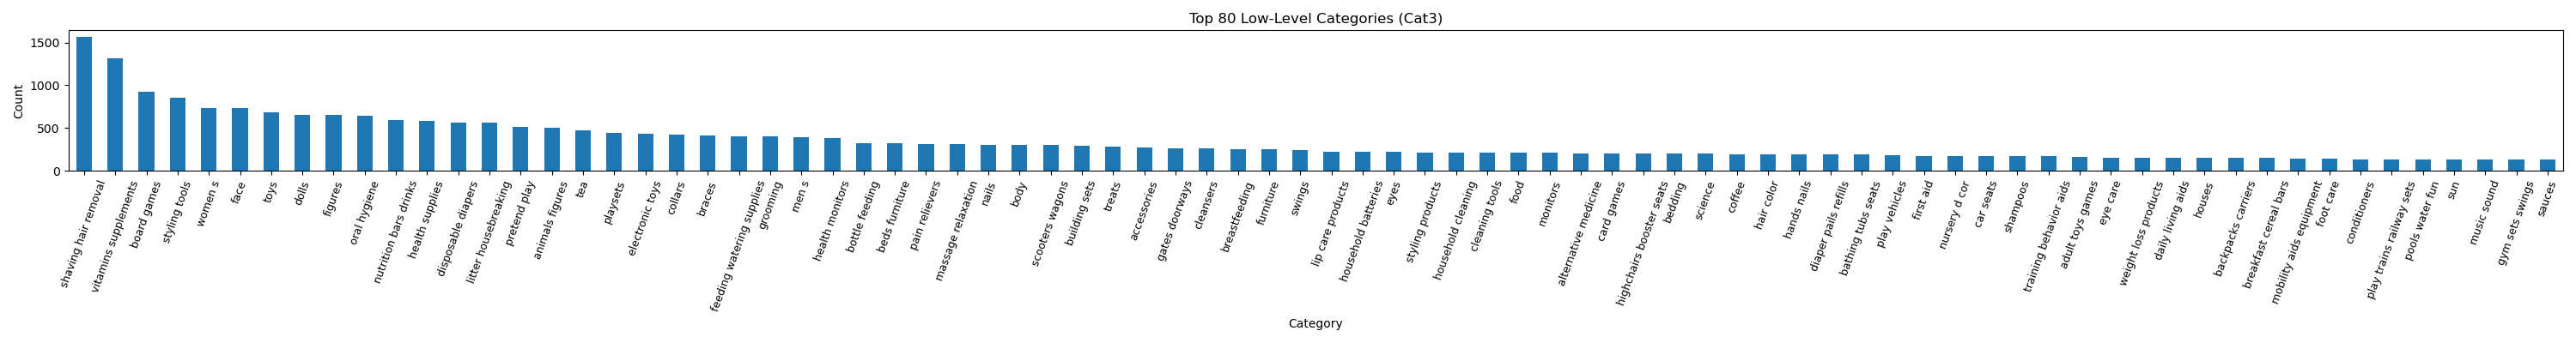

In [19]:
from display_utils import plot_category_counts

# Display top 10 counts for each category
display(pd.DataFrame(train.Cat1.value_counts().head(10)).rename(columns={0: 'Count'}).rename_axis("Top 10 Cat1").reset_index())
display(pd.DataFrame(train.Cat2.value_counts().head(10)).rename(columns={0: 'Count'}).rename_axis("Top 10 Cat2").reset_index())
display(pd.DataFrame(train.Cat3.value_counts().head(10)).rename(columns={0: 'Count'}).rename_axis("Top 10 Cat3").reset_index())

# Run for each level
plot_category_counts(train.Cat1, "Top-Level Category (Cat1)", 1)
plot_category_counts(train.Cat2, "Mid-Level Category (Cat2)", 2)
plot_category_counts(train.Cat3, "Top 80 Low-Level Categories (Cat3)", 3)


## 🔗 Hierarchical Classification

Now, it is time to setup our hierarchical classifier. To this end, we use the **HiClass** Python library.

### 🧠 What is HiClass?

**HiClass** is designed for **hierarchical classification**, where labels follow a tree-like structure (e.g., Category → Subcategory → Sub-subcategory).

Unlike flat classifiers (which ignore label dependencies), HiClass models the **relationships between labels at different levels** — improving both accuracy and interpretability for problems like product categorization, medical coding, and topic classification. HiClass improves robustness by **modeling each level of the hierarchy explicitly**.

---

### 🏗️ HiClass Strategies

HiClass provides multiple strategies for how classifiers are assigned across levels of the hierarchy. These are specified when initializing the classifier.

---

#### 1. `LocalClassifierPerNode` (**LCPN**)

- Trains **one classifier per node** in the hierarchy.
- Each classifier decides which of its **direct children** is correct.
- Most accurate, but can be expensive for large trees.

📌 Ideal when label paths vary a lot and misclassifications at high levels are costly.

---

#### 2. `LocalClassifierPerParentNode` (**LCPPN**)

- Trains one classifier per **parent node** to predict among its children.
- Slightly coarser than LCPN but often faster with similar performance.
- Good default for balanced accuracy and speed.

---

#### 3. `LocalClassifierPerLevel` (**LCPL**)

- Trains one classifier for **each level** (e.g., all `Cat1` nodes together, all `Cat2`, etc.).
- Simpler, faster, but assumes label structure is regular across the dataset.
- May suffer in performance if class imbalance exists across levels.

---

### 🧰 How to Choose a Strategy?

| Strategy | Granularity | Accuracy | Speed | Use Case |
|----------|-------------|----------|-------|----------|
| `LCPN`   | Per node    | ⭐⭐⭐⭐     | ⭐     | High accuracy, small trees |
| `LCPPN`  | Per parent  | ⭐⭐⭐      | ⭐⭐    | Balanced choice            |
| `LCPL`   | Per level   | ⭐⭐       | ⭐⭐⭐   | Fast baseline, regular hierarchies |


For more details, please refer to the **hiclass documents** available here: https://hiclass.readthedocs.io/en/latest/get_started/hierarchical_data.html


### 📈 Probability & Calibration Methods in HiClass

We know while using HiClass (or any other hierarchical classification libraries), predictions are made across multiple levels (e.g., Category → Subcategory → Sub-subcategory). Each prediction at a node in the hierarchy is made by a **local classifier**, such as an `SGDClassifier`, `SVC`, or `RandomForestClassifier`.

By default, these classifiers may output:
- Raw scores (e.g., decision function margins)
- Poorly calibrated or overconfident probabilities
- Inconsistent confidence levels across nodes

This is where **probability and calibration** come in. Fortunately, HiClass provides built-in support for generating probability/confidence scores using both **calibration** and **probability combination** methods.

### 📈 Why We Need Probability Estimates

- **Hierarchical models combine multiple predictions** (one per node or level).
- Without probability estimates, it’s hard to determine how **confident** the model is in its full path prediction.
- Probabilities help in:
  - **Aggregating confidence** across levels (e.g., multiplying probabilities along the path)
  - **Threshold-based decisions** (e.g., "only accept this prediction if confidence > 0.8")
  - **Downstream ranking or filtering** of predictions

---

### 🧪 Why Calibration Is Important

Even if a classifier returns probabilities, they are often **not reliable**. For example:
- An uncalibrated classifier might say it's 95% sure but actually be wrong 40% of the time.
- This is especially true for linear models (like `SGDClassifier`) or small datasets.

**Calibration improves the quality of these probability estimates** by adjusting them to better reflect true likelihoods.

---

#### 🔧 HiClass Calibration Methods

These methods improve the accuracy of probability estimates from base classifiers by adjusting their raw outputs.

You can configure this using the `calibration_method` parameter.

| Method     | Description                                                                 |
|------------|-----------------------------------------------------------------------------|
| `'isotonic'` | Non-parametric calibration using isotonic regression. Good for large datasets. |
| `'platt'`     | Logistic regression model (a.k.a. Platt scaling). Works well on small data.     |
| `'beta'`      | Beta calibration, a parametric alternative with improved flexibility.           |
| `'ivap'`      | Inductive Venn-Abers predictor. Distribution-free and theoretically sound.      |
| `'cvap'`      | Cross Venn-Abers predictor. Similar to IVAP, uses cross-validation.             |

> Use `.calibrate(X_val, y_val)` after `.fit()` to enable calibration.

---

#### 🔗 HiClass Probability Combination Methods

HiClass predicts probabilities at each level of the hierarchy. These methods control **how the probabilities from different levels are aggregated**.

You can configure this using the `probability_combiner` parameter.

| Method        | Description                                                                 |
|---------------|-----------------------------------------------------------------------------|
| `'multiply'`  | Multiplies probabilities across levels (default). Emphasizes dependencies.  |
| `'arithmetic'`| Averages probabilities using arithmetic mean.                               |
| `'geometric'` | Uses geometric mean for aggregation.                                        |
| `None`        | No combination is applied; raw per-level probabilities are returned.        |

---

### ✅ Example:

```python
from hiclass import LocalClassifierPerNode
from sklearn.linear_model import SGDClassifier

model = LocalClassifierPerNode(
    local_classifier=SGDClassifier(loss="hinge"),
    calibration_method='isotonic',
    probability_combiner='geometric'
)

model.fit(X_train, y_train)
model.calibrate(X_val, y_val)  # Calibrates probability estimates
probs = model.predict_proba(X_test)


### ⚙️ Why Do We Still Need a Local Classifier in HiClass?

You see in the above code example, an **SGDClassifier** has been defined as the local_classifier for the LCPN strategy.

HiClass is a **framework** for structuring hierarchical classification. It defines how predictions are made across multiple levels or nodes in a label hierarchy (e.g., using strategies like LCPN, LCPPN, or LCPL).

However, HiClass **does not implement the classifiers themselves** — it relies on standard machine learning models (e.g., `SGDClassifier`, `SVC`, `RandomForestClassifier`) as **local classifiers** at each node or level.

> 🧠 Think of HiClass as the structure and logic — the **"brain"** — while the local classifiers are the actual **"muscles"** doing the learning at each decision point.

You must choose a local classifier that suits your data, classification problem, and computational budget.

---

In our configuration, we use two different base classifiers:

- `LogisticRegression`: A fast, linear model that estimates the probability of class membership using the logistic (sigmoid) function.
- `SGDClassifier`: A fast, linear classifier trained using stochastic gradient descent. It is highly scalable and supports hinge loss (like SVMs).
- **Bootstrapping (Bagging)**: We wrap the `SGDClassifier` with `BaggingClassifier` to improve stability and produce more reliable probability estimates.

#### ✅ Why this combination?

| Component | Role |
|-----------|------|
| `SGDClassifier` | Fast linear model, handles high-dimensional data (like TF-IDF vectors). |
| `BaggingClassifier` | Ensemble of multiple SGD models trained on bootstrapped samples — reduces variance and improves robustness. |
| `HiClass` | Uses this wrapped classifier at **each node** of the hierarchy to make structured predictions. |

This setup allows us to:
- Maintain speed and scalability.
- Improve model confidence through bagging.
- Integrate smoothly with HiClass's hierarchical prediction logic.

> ✅ In summary, even though HiClass handles the hierarchy, each node still needs a **base classifier** — and wrapping it in bootstrapping helps boost performance and reliability.


Please go to 'Cap_code_run' Notebook to test some HiClass models using the introduced base classifiers